In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data

## Declair Dataset Class

In [21]:
class NumIterDataset(data.IterableDataset):
    '''Init: 使用變數宣告- data來源、總量、preprocess方法...等等'''
    def __init__(self,fname,number_length):
        super(NumIterDataset).__init__()
        self.fname=fname
        self.number_length=number_length
    '''長度不宣告也沒差還是可以跑，有時候可以是無窮迴圈dataset'''
#     def __len__(self):
#         return self.number_length
    def prep(self,line):
        d,l=line.split(",")
        return float(d),int(l)
    '''定義iteration的方式，反正此dataset被call到之後開始跑iteration'''
    def __iter__(self):
        file_itr = open(self.fname)
        _=next(file_itr)## 去除掉title
        file_itr=map(self.prep,file_itr)
        for idx,(d,l) in enumerate(file_itr):
            if idx<self.number_length:
                yield d,l
            else:
                break

In [22]:
'''之後就可以用這個dataset class 來query'''
dataset=NumIterDataset("data.csv",6)

## Declair Dataloader Class

In [23]:
'''Data Loader這個class 可以把data load成torch tensor, 預設沒有shuffle,且batch size為1'''
loader=data.DataLoader(dataset)
'''可iterate，每次會依序call 包含dataset的 __getitem__'''
for d,l in loader:
    print(f"{d}{type(d)}|{l} {type(l)}")

tensor([0.3315], dtype=torch.float64)<class 'torch.Tensor'>|tensor([0]) <class 'torch.Tensor'>
tensor([0.2033], dtype=torch.float64)<class 'torch.Tensor'>|tensor([1]) <class 'torch.Tensor'>
tensor([-1.5153], dtype=torch.float64)<class 'torch.Tensor'>|tensor([2]) <class 'torch.Tensor'>
tensor([-0.9327], dtype=torch.float64)<class 'torch.Tensor'>|tensor([3]) <class 'torch.Tensor'>
tensor([-0.7553], dtype=torch.float64)<class 'torch.Tensor'>|tensor([4]) <class 'torch.Tensor'>
tensor([-0.1205], dtype=torch.float64)<class 'torch.Tensor'>|tensor([5]) <class 'torch.Tensor'>


## Batch

In [24]:
'''Data Loader這個class 可以把data load成torch tensor, 預設沒有shuffle,且batch size為1'''
loader=data.DataLoader(dataset,batch_size=2)
'''可設batch參數，一次讀多一點'''
for d,l in loader:
    print(f"{d}{type(d)}|{l} {type(l)}")

tensor([0.3315, 0.2033], dtype=torch.float64)<class 'torch.Tensor'>|tensor([0, 1]) <class 'torch.Tensor'>
tensor([-1.5153, -0.9327], dtype=torch.float64)<class 'torch.Tensor'>|tensor([2, 3]) <class 'torch.Tensor'>
tensor([-0.7553, -0.1205], dtype=torch.float64)<class 'torch.Tensor'>|tensor([4, 5]) <class 'torch.Tensor'>


In [25]:
dataset_=NumIterDataset("data.csv",5000)

In [26]:
loader=data.DataLoader(dataset_)
onset=time.time()
for d,l in loader:
    d=d.cuda() # 把tensor丟進GPU
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.4229888916015625  s


In [27]:
'''若開batch，讀取速度本身會加快一點'''
loader=data.DataLoader(dataset_,batch_size=4)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.1108245849609375  s


In [28]:
'''加大batch size會更快'''
loader=data.DataLoader(dataset_,batch_size=50)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.02150726318359375  s


In [29]:
'''但加大batch size到一定程度，邊際效應遞減'''
loader=data.DataLoader(dataset_,batch_size=100)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.0175473690032959  s


In [30]:
'''Drop last可以把不滿batch_size的丟掉'''
loader=data.DataLoader(dataset,batch_size=5,drop_last=True)
for d,l in loader:
    print(f"{d}{type(d)}|{l} {type(l)}")

tensor([ 0.3315,  0.2033, -1.5153, -0.9327, -0.7553], dtype=torch.float64)<class 'torch.Tensor'>|tensor([0, 1, 2, 3, 4]) <class 'torch.Tensor'>


## Workers

In [31]:
'''Workers number決定多線程執行的程度，預設是0就是沒有分，1以上會去多開執行緒'''
'''在commanand line上打"ps"可以觀察到多開執行緒這件事，開執行緒本身很慢，所以在執行loading很大時才看得出效果'''
dataset__=NumIterDataset("data.csv",500000)
loader=data.DataLoader(dataset__,batch_size=5000)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")


time elapsed: 1.494849681854248  s


In [32]:
loader=data.DataLoader(dataset__,num_workers=1,batch_size=5000)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 1.6852996349334717  s


In [33]:
loader=data.DataLoader(dataset__,num_workers=4,batch_size=5000)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 2.012490749359131  s


**Batch size調小**

In [34]:
'''在資料loading很快時(batch size很小，或是資料大小很小時)，開執行緒只是阻礙'''
loader=data.DataLoader(dataset__,batch_size=10)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 5.1720592975616455  s


In [35]:
loader=data.DataLoader(dataset__,num_workers=1,batch_size=10)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 50.30317497253418  s


In [36]:
loader=data.DataLoader(dataset__,num_workers=4,batch_size=10)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 163.80168223381042  s


**Persistancce workers**

In [37]:
'''剛剛不是說開workers也是要時間嗎?'''
'''使用persistant worker可以再第二次使用時加快速度'''
loader=data.DataLoader(dataset__,num_workers=4,batch_size=5000,persistent_workers=True)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 1.973170280456543  s


In [38]:
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 1.9422776699066162  s


In [39]:
'''第二次使用不見得要全部跑完才算，可以load一組就好'''
loader=data.DataLoader(dataset__,num_workers=4,batch_size=5000,persistent_workers=True)
for d,l in loader:
    break
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 1.8052937984466553  s


## Prefetch

In [40]:
'''預讀取資料，在一筆做完前就開始讀下一筆，設定連續讀數筆batch之後再慢慢一筆筆assign給output，預設預讀2筆'''
'''num_workers一定要大於1'''

'''在資料少的情況下prefetch也可能成為阻礙速度的原因'''
loader=data.DataLoader(dataset__,prefetch_factor=1,num_workers=4,batch_size=5000)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 1.8698930740356445  s


In [41]:
'''但要是 data很多的話這些prefetch就會有點用，資料不多的時候也可以把workers，prefetch關掉'''
loader=data.DataLoader(dataset__+dataset__+dataset__+dataset__+dataset__+dataset__,prefetch_factor=2,num_workers=4,batch_size=5000,persistent_workers=True)
for d,l in loader:
    break
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 11.9212646484375  s


In [42]:
loader=data.DataLoader(dataset__+dataset__+dataset__+dataset__+dataset__+dataset__,prefetch_factor=4,num_workers=4,batch_size=5000,persistent_workers=True)
for d,l in loader:
    break
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 11.047260999679565  s


## Pin memory

In [43]:
'''先把要丟到GPU的Tensor存到暫存空間，從CPU丟到GPU會變快'''
loader=data.DataLoader(dataset__+dataset__+dataset__+dataset__+dataset__+dataset__,prefetch_factor=4,num_workers=4,batch_size=5000,pin_memory=True)
onset=time.time()
for d,l in loader:
    d=d.cuda()
    l=l.cuda()
    pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 11.409748792648315  s


## Shuffle

In [44]:
'''IterDatset不能開shuffle'''
loader=data.DataLoader(dataset,shuffle=True)
for d,l in loader:
    print(f"{d}{type(d)}|{l} {type(l)}")

ValueError: DataLoader with IterableDataset: expected unspecified shuffle option, but got shuffle=True

**1.71版以前有個BufferShuffledDataset，可以使用一個buffer做pseudo shuffle**

**現在沒有了只好自己寫**

In [92]:
a=[1,2,3]
random.shuffle(a)

In [93]:
a

[2, 1, 3]

In [94]:
import random
class ShuffleDataset(data.IterableDataset):
    def __init__(self, dataset, buffer_size):
        super().__init__()
        self.dataset = dataset
        self.buffer_size = buffer_size
    def __iter__(self):
        try:
            dataset_iter = iter(self.dataset)
            shufbuf=[next(dataset_iter) for i in range(self.buffer_size)]
            random.shuffle(shufbuf)
        except:
            self.buffer_size = len(shufbuf)
        try:
            while True:
                try:
                    
                    item = next(dataset_iter)
                    yield shufbuf.pop()
                    shufbuf.append(item)
                    random.shuffle(shufbuf)
                except StopIteration:
                    break
            while len(shufbuf) > 0:
                yield shufbuf.pop()
        except GeneratorExit:
            pass


In [95]:
shuffle_dataset=ShuffleDataset(dataset,buffer_size=3)
loader=data.DataLoader(shuffle_dataset)
for d,l in loader:
    print(f"{d}{type(d)}|{l} {type(l)}")

tensor([0.3315], dtype=torch.float64)<class 'torch.Tensor'>|tensor([0]) <class 'torch.Tensor'>
tensor([-0.9327], dtype=torch.float64)<class 'torch.Tensor'>|tensor([3]) <class 'torch.Tensor'>
tensor([-1.5153], dtype=torch.float64)<class 'torch.Tensor'>|tensor([2]) <class 'torch.Tensor'>
tensor([0.2033], dtype=torch.float64)<class 'torch.Tensor'>|tensor([1]) <class 'torch.Tensor'>
tensor([0.6372], dtype=torch.float64)<class 'torch.Tensor'>|tensor([6]) <class 'torch.Tensor'>
tensor([-0.1205], dtype=torch.float64)<class 'torch.Tensor'>|tensor([5]) <class 'torch.Tensor'>
tensor([-0.1704], dtype=torch.float64)<class 'torch.Tensor'>|tensor([7]) <class 'torch.Tensor'>
tensor([1.0863], dtype=torch.float64)<class 'torch.Tensor'>|tensor([8]) <class 'torch.Tensor'>
tensor([-1.5793], dtype=torch.float64)<class 'torch.Tensor'>|tensor([9]) <class 'torch.Tensor'>
tensor([-0.7553], dtype=torch.float64)<class 'torch.Tensor'>|tensor([4]) <class 'torch.Tensor'>


In [98]:
'''可是這個buffer如果小於前面的資料數，那亂的程度就會受到影響'''
dataset=NumIterDataset("data.csv",10)
shuffle_dataset=ShuffleDataset(dataset,buffer_size=3)
loader=data.DataLoader(shuffle_dataset,batch_size=10)

In [99]:
l=[]
for epoch in range(1000):
    for d,i in loader:
        l.append(i)    
a=torch.stack(l,axis=-1)

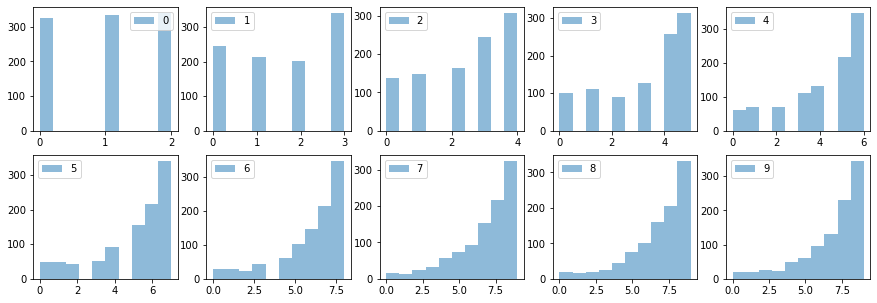

In [100]:
'''統計一下會發現，batch第一次抽到的可能性只落在三種選擇內，第二次的是4種，依此類推，越後面的越容易在更後面抽到'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [101]:
'''如果buffer數到了一定數量就比較好用一點'''
dataset=NumIterDataset("data.csv",10)
shuffle_dataset=ShuffleDataset(dataset,buffer_size=8)
loader=data.DataLoader(shuffle_dataset,batch_size=10)

In [102]:
l=[]
for epoch in range(1000):
    for d,i in loader:
        l.append(i)    
a=torch.stack(l,axis=-1)

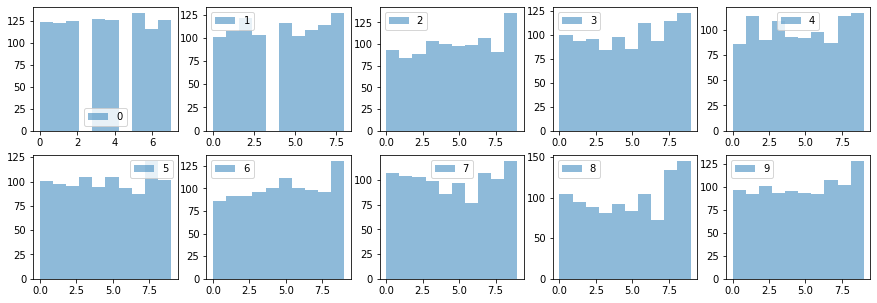

In [103]:
'''雖然前幾次的會不太隨機，但是後面的都很隨機'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [109]:
dataset=NumIterDataset("data.csv",100)
loader=data.DataLoader(dataset,batch_size=10)
onset=time.time()
for epoch in range(1000):
    for d,i in loader:
        pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.5729472637176514  s


In [110]:
dataset=NumIterDataset("data.csv",100)
shuffle_dataset=ShuffleDataset(dataset,buffer_size=50)
loader=data.DataLoader(shuffle_dataset,batch_size=10)
onset=time.time()
for epoch in range(1000):
    for d,i in loader:
        pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 2.9174273014068604  s


自製的shuffle還是慢了一點

In [149]:
import numpy as np
class ShuffleDataset(data.IterableDataset):
    def __init__(self, fname,number_length, buffer_size):
        super().__init__()
        self.fname=fname
        self.number_length=number_length
        self.buffer_size = buffer_size
    def prep(self,line):
        d,l=line.split(",")
        return float(d),int(l)
    def __iter__(self):
        # Initial iteration
        file_itr = open(self.fname)
        _=next(file_itr)
        # Assign preprocess function
        file_itr=map(self.prep,file_itr)
        # Setup shuffle buffer
        shufbuf=[next(file_itr) for i in range(self.buffer_size)]
        order=np.random.randint(0,self.buffer_size,(self.number_length-self.buffer_size))
        order_last=np.random.permutation(self.buffer_size)
        try:
            for idx,item in enumerate(file_itr):
                if idx<self.number_length:
                    if idx>=self.number_length-self.buffer_size:
                        yield shufbuf[order_last[self.number_length-idx-1]]
                    else:
                        yield shufbuf[order[idx]]
                        shufbuf[order[idx]]=item
                    continue
                break
        except GeneratorExit:
            pass


In [150]:
shuffle_dataset=ShuffleDataset("data.csv",10,buffer_size=3)
loader=data.DataLoader(shuffle_dataset,batch_size=10)

In [151]:
l=[]
for epoch in range(1000):
    for d,i in loader:
        l.append(i)    
a=torch.stack(l,axis=-1)

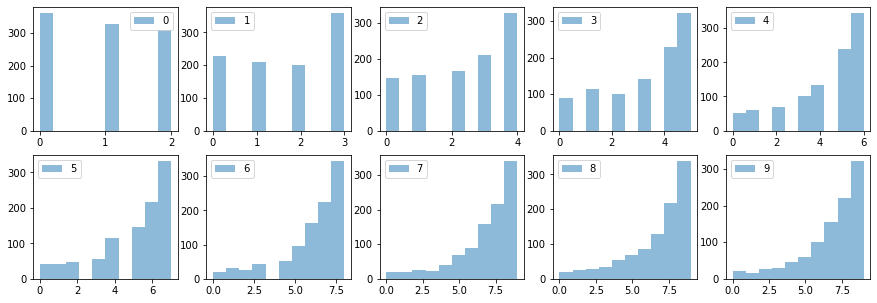

In [152]:
'''雖然前幾次的會不太隨機，但是後面的都很隨機'''
plt.figure(figsize=(15,5))
for i,ii in enumerate(a.numpy()):
    plt.subplot(2,5,i+1)
    plt.hist(ii,alpha=0.5,label=[i])
    plt.legend()

In [153]:
shuffle_dataset=ShuffleDataset("data.csv",100,buffer_size=50)
loader=data.DataLoader(shuffle_dataset,batch_size=10)

In [154]:
onset=time.time()
for epoch in range(1000):
    for d,i in loader:
        pass
print("time elapsed:",time.time()-onset," s")

time elapsed: 0.8011782169342041  s
